In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.optimize import curve_fit

#Use better looking plot settings
plt.rc('font',family='serif')

In [2]:
## Code here or write here
## Read in the advertising data
RootData = pd.read_csv("Root_Insurance_data.csv")

## Make a train test split, setting aside 25% of the data as a test for later
#RootData_train = RootData.copy().sample(frac=.75,random_state = 23)
#RootData_test = RootData.copy().drop(RootData.index)

#Actually don't think we need these yet

In [3]:
RootData

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
0,unknown,2,1,M,10.0,2,False,0
1,Y,3,1,M,10.0,5,False,0
2,Y,3,2,M,10.0,5,False,0
3,N,3,2,S,10.0,4,False,0
4,unknown,2,2,S,10.0,2,False,0
...,...,...,...,...,...,...,...,...
9995,N,1,2,S,10.0,3,True,0
9996,unknown,3,2,M,10.0,3,False,0
9997,Y,3,1,S,10.0,5,False,0
9998,unknown,3,1,M,10.0,3,False,0


In [4]:
print(RootData["policies_sold"].min())
print(RootData["policies_sold"].max())

0
1


Okay, so we know that customers only ever bought 1 policy at a time.
No need to plan for multi-policy purchases in our analysis.

In [5]:
def basic_info(Category=None, Value=None, RankNum=0, printout=True):
    # Find the clicks per ad, policies sold per ad, and policies sold per click for a subset of the data
    # Return these values, along with their associated uncertainties
    
    if Category==None: #get all the data without cutting on a condition
        ad_clicks = len( RootData.loc[RootData["click"]==True] )
        policies_sold = len( RootData.loc[RootData["policies_sold"]==1] )
        total_ads = len(RootData)
        print(total_ads,'total ads')
        print(ad_clicks,'ad clicks')
        print(policies_sold,'policies sold')
    elif RankNum == 0: #look at only the data specified by the Category and its Value
        ad_clicks = len(RootData.loc[(RootData["click"]==True) & (RootData[Category]==Value)])
        policies_sold = len(RootData.loc[(RootData["policies_sold"]==1) & (RootData[Category]==Value)])
        total_ads = len(RootData.loc[RootData[Category]==Value])
    else: #look at only the data specified by the Category and its Value for rank=RankNum
        ad_clicks = len(RootData.loc[(RootData["click"]==True) & (RootData["rank"]==RankNum) & (RootData[Category]==Value)])
        policies_sold = len(RootData.loc[(RootData["policies_sold"]==1) & (RootData["rank"]==RankNum) & (RootData[Category]==Value)])
        total_ads = len(RootData.loc[(RootData["rank"]==RankNum) & (RootData[Category]==Value)])
    
    #print(ad_clicks,'ad clicks')
    #print(policies_sold,'policies sold')
    #print(total_ads,'total ads')
    
    if total_ads > 0:
        clicks_per_ad = ad_clicks/total_ads
        policies_per_ad = policies_sold/total_ads
        policies_per_click = policies_per_ad/clicks_per_ad
        err_clicks_per_ad = clicks_per_ad * np.sqrt((np.sqrt(ad_clicks)/ad_clicks)**2+(np.sqrt(total_ads)/total_ads)**2 )
        err_policies_per_ad = policies_per_ad * np.sqrt((np.sqrt(policies_sold)/policies_sold)**2+(np.sqrt(total_ads)/total_ads)**2 )
        err_policies_per_click = policies_per_click * np.sqrt((err_policies_per_ad/policies_per_ad)**2+(err_clicks_per_ad/clicks_per_ad)**2 )
    else:
        return ['---', '---', '---', '---', '---', '---']
    
    if printout == True:
        #print(ad_clicks,'ad clicks')
        #print(policies_sold,'policies sold')
        #print(total_ads,'total ads')
        print(round(clicks_per_ad,3),'+/-',round(err_clicks_per_ad,4),'clicks per ad')
        print(round(policies_per_ad,3),'+/-',round(err_policies_per_ad,4),'policies sold per ad')
        print(round(policies_per_click,3),'+/-',round(err_policies_per_click,4),'policies sold per click')
    
    return [clicks_per_ad, err_clicks_per_ad, policies_per_ad, err_policies_per_ad, policies_per_click, err_policies_per_click]

In [6]:
#Let's check out basic information for each of our categories
print('Aggregate for all ads:')
basic_info()
print()
print('Ads targeting those known to currently have insurance:')
basic_info("Currently Insured","Y")
print('Ads targeting those known NOT to currently have insurance:')
basic_info("Currently Insured","N")
print('Ads targeting those of unknown insurance status:')
basic_info("Currently Insured","unknown")
print()
print('Ads targeting those with 1 vehicle:')
basic_info("Number of Vehicles",1)
print('Ads targeting those with 2 vehicles:')
basic_info("Number of Vehicles",2)
print('Ads targeting those with 3 vehicles:')
basic_info("Number of Vehicles",3)
print()
print('Ads targeting those with 1 driver:')
basic_info("Number of Drivers",1)
print('Ads targeting those with 2 drivers:')
basic_info("Number of Drivers",2)
print()
print('Ads targeting those who are single:')
basic_info("Marital Status","S")
print('Ads targeting those who are married:')
basic_info("Marital Status","M")
print()
print('Ads displayed at rank 1:')
basic_info("rank",1)
print('Ads displayed at rank 2:')
basic_info("rank",2)
print('Ads displayed at rank 3:')
basic_info("rank",3)
print('Ads displayed at rank 4:')
basic_info("rank",4)
print('Ads displayed at rank 5:')
basic_info("rank",5)
print()

Aggregate for all ads:
10000 total ads
1878 ad clicks
783 policies sold
0.188 +/- 0.0047 clicks per ad
0.078 +/- 0.0029 policies sold per ad
0.417 +/- 0.0187 policies sold per click

Ads targeting those known to currently have insurance:
0.121 +/- 0.0063 clicks per ad
0.039 +/- 0.0034 policies sold per ad
0.322 +/- 0.033 policies sold per click
Ads targeting those known NOT to currently have insurance:
0.113 +/- 0.006 clicks per ad
0.051 +/- 0.0039 policies sold per ad
0.448 +/- 0.0423 policies sold per click
Ads targeting those of unknown insurance status:
0.343 +/- 0.0121 clicks per ad
0.152 +/- 0.0075 policies sold per ad
0.442 +/- 0.0268 policies sold per click

Ads targeting those with 1 vehicle:
0.279 +/- 0.0102 clicks per ad
0.128 +/- 0.0065 policies sold per ad
0.457 +/- 0.0285 policies sold per click
Ads targeting those with 2 vehicles:
0.163 +/- 0.0074 clicks per ad
0.062 +/- 0.0044 policies sold per ad
0.382 +/- 0.032 policies sold per click
Ads targeting those with 3 vehicl

In [7]:
#Let's see if rank values have any obvious correlation to policies sold per click
rank_vals = [1,2,3,4,5]
cpa_ranks = []
cpa_err_ranks = []
pspc_ranks = []
pspc_err_ranks = []
for rank_val in rank_vals:
    info_params = basic_info("rank",rank_val,printout=False)
    cpa_ranks.append( info_params[0] ) #first entry returns clicks per ad
    cpa_err_ranks.append( info_params[1] ) #second entry returns the uncertainty in clicks per ad
    pspc_ranks.append( info_params[4] ) #fifth entry returns policies sold per click
    pspc_err_ranks.append( info_params[5] ) #sixth entry returns the uncertainty in policies sold per click

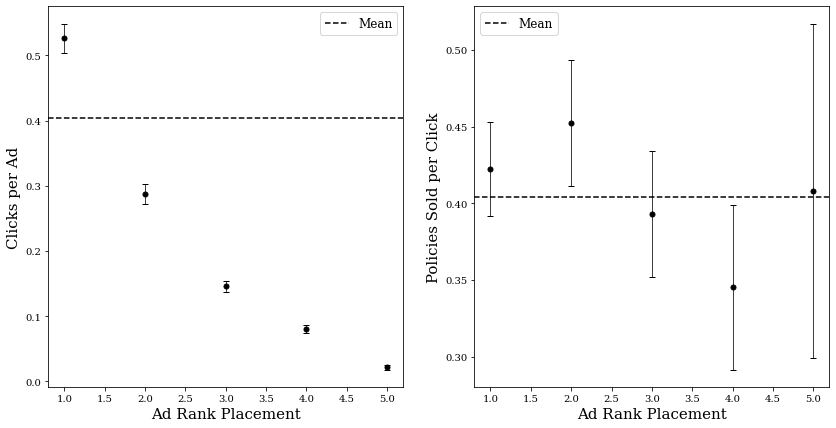

In [8]:
plt.figure(figsize=(14,7))

#First look at clicks per ad as a function of rank placement
plt.subplot(1,2,1)

plt.errorbar(x=rank_vals, y=cpa_ranks, yerr=cpa_err_ranks, color='k', fmt='o',
             capsize=3, linewidth=0.75, markersize=5)
plt.axhline(np.mean(pspc_ranks),color='k',linestyle='--',label='Mean')

plt.legend(fontsize=12)
plt.xlabel('Ad Rank Placement',fontsize=15)
plt.ylabel('Clicks per Ad',fontsize=15)


#Second look at policies sold per click as a function of rank placement
plt.subplot(1,2,2)
plt.errorbar(x=rank_vals, y=pspc_ranks, yerr=pspc_err_ranks, color='k', fmt='o',
             capsize=3, linewidth=0.75, markersize=5)
mean_pspc = np.mean(pspc_ranks)
plt.axhline(mean_pspc,color='k',linestyle='--',label='Mean')

plt.legend(fontsize=12)
plt.xlabel('Ad Rank Placement',fontsize=15)
plt.ylabel('Policies Sold per Click',fontsize=15)

plt.show()

So it is clear that rank placement plays a strong role in determining clicks per ad, but once you succeed in getting the customer to actually click on the ad it seems to stop being a factor. The error bars in the plots above are $1\sigma$, so if it is true that policies sold per click is uneffected by rank placement, we would expect that for 68\% of the points their uncertainty regions would include the mean. We can see that this is the case for 3 of the 5 points, and by eye we can tell that if we double the error bars to a width of $2\sigma$ (in which case 95\% of the points' uncertainty regions should overlap the mean) it holds true for all 5 of them. Basically, in this scenario we expect that all points are making the same measurement and that is indeed consistent with what we find.

TL;DR: Ad rank placement drives clicks, not sales.

/Users/vallely.7/.conda/envs/python/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/vallely.7/.conda/envs/python/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            OLS Regression Results                            
Dep. Variable:          Clicks per Ad   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     30.84
Date:                Sun, 16 May 2021   Prob (F-statistic):             0.0115
Time:                        23:29:25   Log-Likelihood:                 7.5294
No. Observations:                   5   AIC:                            -11.06
Df Residuals:                       3   BIC:                            -11.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5774      0.073      7.945      0.0

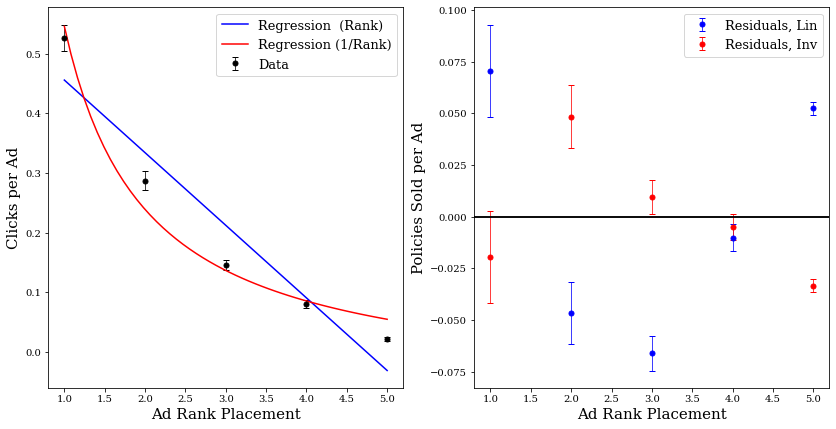

Chi^2/dof for Linear Fit: 124.316213811848
Chi^2/dof for Inverse Fit: 43.347186054629525


In [9]:
#Alright, let's see if we can get a decent fit for clicks per ad as a function of rank placement
#We'll start by trying some of the linear regression stuff we've been doing in lectures this week

#That figure above looks something like y~1/x,
#so we'll include a 1/rank term in the dataframe for us to use for linear regression
rank_df = pd.DataFrame({
                        'Rank':rank_vals,
                        'Clicks per Ad':cpa_ranks,
                        'Clicks per Ad Uncertainty':cpa_err_ranks,
                        'Inverse Rank':1.0/np.array(rank_vals)
                        })

#First do a simple linear fit to rank
fit_lin = sm.OLS(rank_df['Clicks per Ad'], sm.add_constant(rank_df[['Rank']]) ).fit()
fit_lin_betas = list(fit_lin.params)
print(fit_lin.summary())

#Now try fitting to 1/rank since the curve seems reminiscent of y~1/x
fit_inv = sm.OLS(rank_df['Clicks per Ad'], sm.add_constant(rank_df[['Inverse Rank']]) ).fit()
fit_inv_betas = list(fit_inv.params)
print(fit_inv.summary())

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)

x = np.linspace(1,5,50)
regression_lin = fit_lin_betas[0] + fit_lin_betas[1]*x
regression_inv = fit_inv_betas[0] + fit_inv_betas[1]*(1.0/x)

plt.errorbar(x=rank_vals, y=cpa_ranks, yerr=cpa_err_ranks, color='k', fmt='o',
             capsize=3, linewidth=0.75, markersize=5, label='Data')
plt.plot(x, regression_lin, color='blue', label='Regression  (Rank)')
plt.plot(x, regression_inv, color='red', label='Regression (1/Rank)')

plt.legend(fontsize=13)
plt.xlabel('Ad Rank Placement',fontsize=15)
plt.ylabel('Clicks per Ad',fontsize=15)


#Let's check residuals too
plt.subplot(1,2,2)
residuals_lin = rank_df["Clicks per Ad"] - (fit_lin_betas[0] + fit_lin_betas[1]*rank_df["Rank"])
residuals_inv = rank_df["Clicks per Ad"] - (fit_inv_betas[0] + fit_inv_betas[1]*rank_df["Inverse Rank"])



plt.errorbar(x=rank_df["Rank"], y=residuals_lin, yerr=cpa_err_ranks,
             fmt='o', capsize=3, linewidth=0.75, markersize=5,
             color='b', label='Residuals, Lin')
plt.errorbar(x=rank_df["Rank"], y=residuals_inv, yerr=cpa_err_ranks,
             fmt='o', capsize=3, linewidth=0.75, markersize=5,
             color='r', label='Residuals, Inv')
plt.axhline(0,color='k')
plt.axhline(0,color='k')

plt.xlabel('Ad Rank Placement',fontsize=15)
plt.ylabel('Policies Sold per Ad',fontsize=15)

plt.legend(fontsize=13)
plt.show()

plt.show()

#since we have 2 parameters we're fitting the dof is N-2
#At least I think that's true. It might actually be N-3?
dof = len(rank_df["Clicks per Ad"]) - 2

#Since our points have known, non-uniform uncertainty chi^2/dof is a better metric than MSE
print('Chi^2/dof for Linear Fit:',sum((residuals_lin/cpa_err_ranks)**2)/dof)
print('Chi^2/dof for Inverse Fit:',sum((residuals_inv/cpa_err_ranks)**2)/dof)

I've included the $1\sigma$ error bars above to help us understand our data and the fits better, but it's important to note that the regression done here isn't actually using them and is simply fitting to 5 data points it assumes have equal variance.

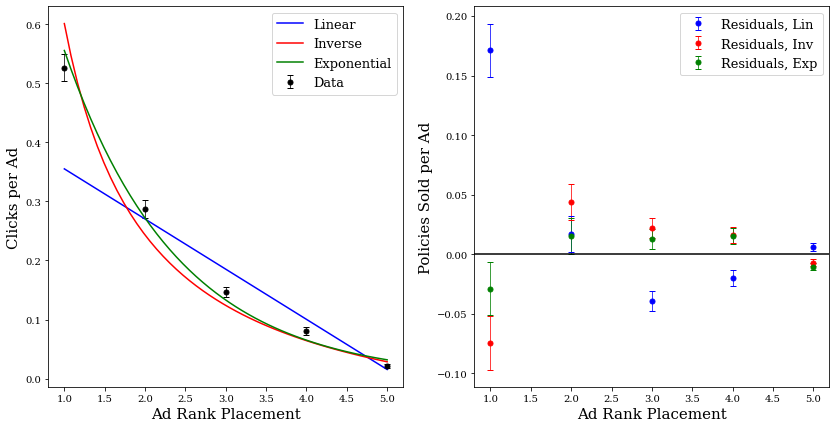

Updated Chi^2/dof for Linear Fit: 31.749235682114968
Updated Chi^2/dof for Inverse Fit: 12.768276734731375
Updated Chi^2/dof for Exponential Fit: 7.453687823694167


In [10]:
#Let's try using curve_fit, since that allows us to weight using the uncertainties

#First define the y~x and y~1/x functions
def f_lin(x, B0, B1):
    return B0 + B1*x

def f_inv(x, B0, B1):
    return B0 + B1*1.0/x

#Let's try an exponential too since it feels like a form that'd make sense here
def f_exp(x, B0, B1):
    return B0*np.exp(B1*x)

#now fit to them, storing the best-fit parameters in the two betas lists as before
fit_lin_betas, fit_lin_cov = curve_fit(f_lin, rank_df["Rank"], rank_df["Clicks per Ad"],
                                       sigma=cpa_err_ranks, absolute_sigma=True, method='trf')
fit_inv_betas, fit_inv_cov = curve_fit(f_inv, rank_df["Rank"], rank_df["Clicks per Ad"],
                                       sigma=cpa_err_ranks, absolute_sigma=True, method='trf')
fit_exp_betas, fit_exp_cov = curve_fit(f_exp, rank_df["Rank"], rank_df["Clicks per Ad"],
                                       sigma=cpa_err_ranks, absolute_sigma=True, method='trf')

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)

#plot best-fit curves
x = np.linspace(1,5,50)
regression_lin = f_lin(x,fit_lin_betas[0],fit_lin_betas[1]) #fit_lin_betas[0] + fit_lin_betas[1]*x
regression_inv = f_inv(x,fit_inv_betas[0],fit_inv_betas[1]) #fit_inv_betas[0] + fit_inv_betas[1]*(1.0/x)
regression_exp = f_exp(x,fit_exp_betas[0],fit_exp_betas[1]) #fit_exp_betas[0]*np.(fit_exp_betas[1]*x)

plt.errorbar(x=rank_df["Rank"], y=cpa_ranks, yerr=cpa_err_ranks, color='k', fmt='o',
             capsize=3, linewidth=0.75, markersize=5, label='Data')
plt.plot(x, regression_lin, color='blue', label='Linear')
plt.plot(x, regression_inv, color='red', label='Inverse')
plt.plot(x, regression_exp, color='green', label='Exponential')

plt.legend(fontsize=13)
plt.xlabel('Ad Rank Placement',fontsize=15)
plt.ylabel('Clicks per Ad',fontsize=15)

#Let's again compare residuals
plt.subplot(1,2,2)

residuals_lin = rank_df["Clicks per Ad"] - (fit_lin_betas[0] + fit_lin_betas[1]*rank_df["Rank"])
residuals_inv = rank_df["Clicks per Ad"] - (fit_inv_betas[0] + fit_inv_betas[1]*rank_df["Inverse Rank"])
residuals_exp = rank_df["Clicks per Ad"] - (fit_exp_betas[0]*np.exp(fit_exp_betas[1]*rank_df["Rank"]))

plt.errorbar(x=rank_df["Rank"], y=residuals_lin, yerr=cpa_err_ranks,
             fmt='o', capsize=3, linewidth=0.75, markersize=5,
             color='b', label='Residuals, Lin')
plt.errorbar(x=rank_df["Rank"], y=residuals_inv, yerr=cpa_err_ranks,
             fmt='o', capsize=3, linewidth=0.75, markersize=5,
             color='r', label='Residuals, Inv')
plt.errorbar(x=rank_df["Rank"], y=residuals_exp, yerr=cpa_err_ranks,
             fmt='o', capsize=3, linewidth=0.75, markersize=5,
             color='g', label='Residuals, Exp')
plt.axhline(0,color='k')

plt.xlabel('Ad Rank Placement',fontsize=15)
plt.ylabel('Policies Sold per Ad',fontsize=15)

plt.legend(fontsize=13)

plt.show()


#since we have 2 parameters that we're fitting, the dof is N-2
#At least I think that's true. It might actually be N-3?
dof = len(rank_df["Clicks per Ad"]) - 2

print('Updated Chi^2/dof for Linear Fit:',sum((residuals_lin/cpa_err_ranks)**2)/dof)
print('Updated Chi^2/dof for Inverse Fit:',sum((residuals_inv/cpa_err_ranks)**2)/dof)
print('Updated Chi^2/dof for Exponential Fit:',sum((residuals_exp/cpa_err_ranks)**2)/dof)

Both qualitatively by eye and more rigorously in terms of reduced chi^2, it seems like the best descriptor is an exponential decay after all.

### Next it'd be good to investigate whether this relationship between ad rank placement and clicks per ad holds for subsets of the table (like customers with insurance, those with 2 vehicles, etc) or not.

In [11]:
rank_vals = [1,2,3,4,5]
insured_vals = list( set(RootData["Currently Insured"]) )

#Define an empty dataframe for us to fill in a second
insured_df = pd.DataFrame({
                        'Insured':[],
                        'RankNum':[],
                        'Clicks per Ad':[],
                        'Clicks per Ad Uncertainty':[],
                        'Policies Sold per Click':[],
                        'Policies Sold per Click Uncertainty':[],
                           })

for insured_val in insured_vals:
    cpa_ranks = []
    cpa_err_ranks = []
    pspc_ranks = []
    pspc_err_ranks = []
    for rank_val in rank_vals:
        info_params = basic_info("Currently Insured",insured_val,RankNum=rank_val,printout=False)
        #first entry returns clicks per ad
        #second entry returns the uncertainty in clicks per ad
        #fifth entry returns policies sold per click
        #sixth entry returns the uncertainty in policies sold per click
        if not '---' in info_params: #seems an easy way to not deal with empty rank bins
            new_row = {'Insured':insured_val, 'RankNum':rank_val, 'Clicks per Ad':info_params[0],
                   'Clicks per Ad Uncertainty':info_params[1], 'Policies Sold per Click':info_params[4],
                    'Policies Sold per Click Uncertainty':info_params[5] }
            insured_df = insured_df.append(new_row, ignore_index=True)

insured_df

,Insured,RankNum,Clicks per Ad,Clicks per Ad Uncertainty,Policies Sold per Click,Policies Sold per Click Uncertainty
0,Y,1.0,0.586826,0.074673,0.418367,0.090284
1,Y,2.0,0.298969,0.036531,0.333333,0.076630
2,Y,3.0,0.151134,0.014802,0.283333,0.056853
3,Y,4.0,0.084287,0.009752,0.246914,0.062673
4,Y,5.0,0.022388,0.004357,0.333333,0.129016
5,N,1.0,0.524590,0.080967,0.359375,0.098744
6,N,2.0,0.288770,0.031545,0.527778,0.094634
7,N,3.0,0.138085,0.013229,0.411290,0.071118
8,N,4.0,0.072539,0.008979,0.457143,0.099745
9,N,5.0,0.020276,0.004367,0.500000,0.185881


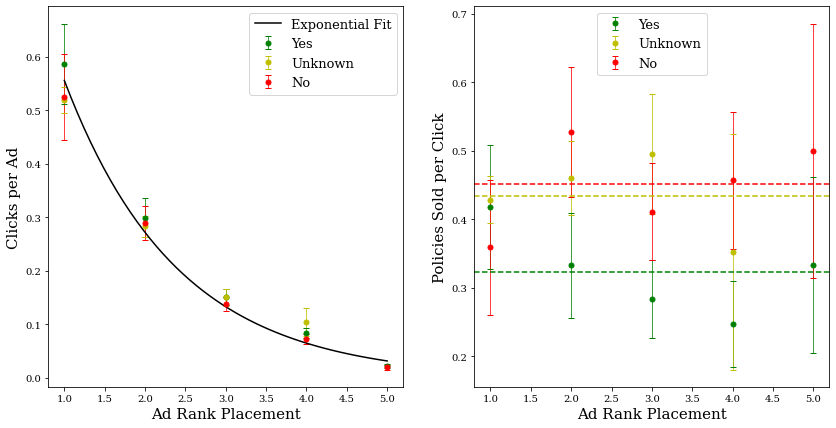

In [12]:
plt.figure(figsize=(14,7))

plt.subplot(1,2,1)

plt.errorbar(x=insured_df["RankNum"].loc[insured_df["Insured"]=='Y'],
             y=insured_df["Clicks per Ad"].loc[insured_df["Insured"]=='Y'],
             yerr=insured_df["Clicks per Ad Uncertainty"].loc[insured_df["Insured"]=='Y'],
             color='g', label='Yes',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)

plt.errorbar(x=insured_df["RankNum"].loc[insured_df["Insured"]=='unknown'],
             y=insured_df["Clicks per Ad"].loc[insured_df["Insured"]=='unknown'],
             yerr=insured_df["Clicks per Ad Uncertainty"].loc[insured_df["Insured"]=='unknown'],
             color='y', label='Unknown',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)

plt.errorbar(x=insured_df["RankNum"].loc[insured_df["Insured"]=='N'],
             y=insured_df["Clicks per Ad"].loc[insured_df["Insured"]=='N'],
             yerr=insured_df["Clicks per Ad Uncertainty"].loc[insured_df["Insured"]=='N'],
             color='r', label='No',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)

plt.plot(x, regression_exp, color='k', label='Exponential Fit')

plt.legend(fontsize=13)
plt.xlabel('Ad Rank Placement',fontsize=15)
plt.ylabel('Clicks per Ad',fontsize=15)



plt.subplot(1,2,2)

plt.errorbar(x=insured_df["RankNum"].loc[insured_df["Insured"]=='Y'],
             y=insured_df["Policies Sold per Click"].loc[insured_df["Insured"]=='Y'],
             yerr=insured_df["Policies Sold per Click Uncertainty"].loc[insured_df["Insured"]=='Y'],
             color='g', label='Yes',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)
plt.axhline( np.mean(insured_df["Policies Sold per Click"].loc[insured_df["Insured"]=='Y']),
            color='g', linestyle='--' )

plt.errorbar(x=insured_df["RankNum"].loc[insured_df["Insured"]=='unknown'],
             y=insured_df["Policies Sold per Click"].loc[insured_df["Insured"]=='unknown'],
             yerr=insured_df["Policies Sold per Click Uncertainty"].loc[insured_df["Insured"]=='unknown'],
             color='y', label='Unknown',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)
plt.axhline( np.mean(insured_df["Policies Sold per Click"].loc[insured_df["Insured"]=='unknown']),
            color='y', linestyle='--' )

plt.errorbar(x=insured_df["RankNum"].loc[insured_df["Insured"]=='N'],
             y=insured_df["Policies Sold per Click"].loc[insured_df["Insured"]=='N'],
             yerr=insured_df["Policies Sold per Click Uncertainty"].loc[insured_df["Insured"]=='N'],
             color='r', label='No',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)
plt.axhline( np.mean(insured_df["Policies Sold per Click"].loc[insured_df["Insured"]=='N']),
            color='r', linestyle='--' )

plt.legend(fontsize=13)
plt.xlabel('Ad Rank Placement',fontsize=15)
plt.ylabel('Policies Sold per Click',fontsize=15)

plt.show()

In [13]:
rank_vals = [1,2,3,4,5]
vehicles_vals = list( set(RootData["Number of Vehicles"]) )

#Define an empty dataframe for us to fill in a second
vehicles_df = pd.DataFrame({
                        'Vehicles':[],
                        'RankNum':[],
                        'Clicks per Ad':[],
                        'Clicks per Ad Uncertainty':[],
                        'Policies Sold per Click':[],
                        'Policies Sold per Click Uncertainty':[],
                           })

for vehicles_val in vehicles_vals:
    cpa_ranks = []
    cpa_err_ranks = []
    pspc_ranks = []
    pspc_err_ranks = []
    for rank_val in rank_vals:
        info_params = basic_info("Number of Vehicles",vehicles_val,RankNum=rank_val,printout=False)
        #first entry returns clicks per ad
        #second entry returns the uncertainty in clicks per ad
        #fifth entry returns policies sold per click
        #sixth entry returns the uncertainty in policies sold per click
        if not '---' in info_params: #seems an easy way to not deal with empty rank bins
            new_row = {'Vehicles':vehicles_val, 'RankNum':rank_val, 'Clicks per Ad':info_params[0],
                   'Clicks per Ad Uncertainty':info_params[1], 'Policies Sold per Click':info_params[4],
                    'Policies Sold per Click Uncertainty':info_params[5] }
            vehicles_df = vehicles_df.append(new_row, ignore_index=True)

vehicles_df

,Vehicles,RankNum,Clicks per Ad,Clicks per Ad Uncertainty,Policies Sold per Click,Policies Sold per Click Uncertainty
0,1.0,1.0,0.538976,0.030392,0.460744,0.043167
1,1.0,2.0,0.309890,0.021120,0.471631,0.054315
2,1.0,3.0,0.160734,0.014187,0.422819,0.066508
3,1.0,4.0,0.077213,0.012515,0.439024,0.127023
4,1.0,5.0,0.028571,0.012959,0.400000,0.337385
5,2.0,1.0,0.509804,0.037041,0.374126,0.047922
6,2.0,2.0,0.237581,0.025200,0.427273,0.079577
7,2.0,3.0,0.123656,0.013666,0.391304,0.079557
8,2.0,4.0,0.080576,0.011193,0.285714,0.082430
9,2.0,5.0,0.018981,0.004396,0.473684,0.192843


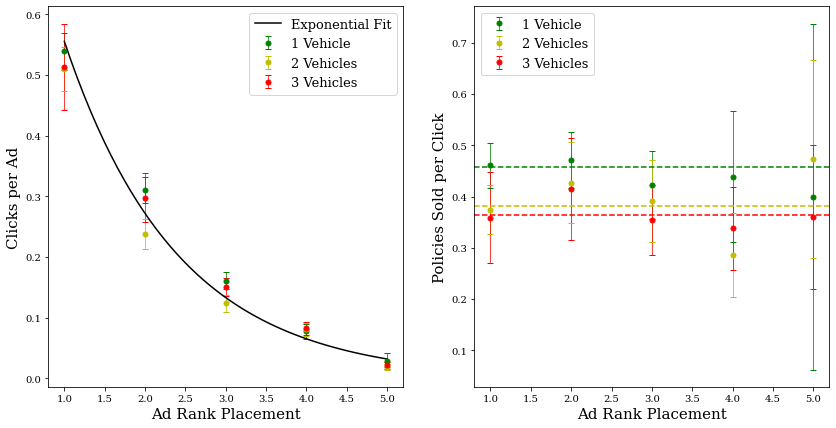

In [14]:
plt.figure(figsize=(14,7))

plt.subplot(1,2,1)

plt.errorbar(x=vehicles_df["RankNum"].loc[vehicles_df["Vehicles"]==1],
             y=vehicles_df["Clicks per Ad"].loc[vehicles_df["Vehicles"]==1],
             yerr=vehicles_df["Clicks per Ad Uncertainty"].loc[vehicles_df["Vehicles"]==1],
             color='g', label='1 Vehicle',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)
plt.errorbar(x=vehicles_df["RankNum"].loc[vehicles_df["Vehicles"]==2],
             y=vehicles_df["Clicks per Ad"].loc[vehicles_df["Vehicles"]==2],
             yerr=vehicles_df["Clicks per Ad Uncertainty"].loc[vehicles_df["Vehicles"]==2],
             color='y', label='2 Vehicles',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)
plt.errorbar(x=vehicles_df["RankNum"].loc[vehicles_df["Vehicles"]==3],
             y=vehicles_df["Clicks per Ad"].loc[vehicles_df["Vehicles"]==3],
             yerr=vehicles_df["Clicks per Ad Uncertainty"].loc[vehicles_df["Vehicles"]==3],
             color='r', label='3 Vehicles',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)

plt.plot(x, regression_exp, color='k', label='Exponential Fit')

plt.legend(fontsize=13)
plt.xlabel('Ad Rank Placement',fontsize=15)
plt.ylabel('Clicks per Ad',fontsize=15)



plt.subplot(1,2,2)

plt.errorbar(x=vehicles_df["RankNum"].loc[vehicles_df["Vehicles"]==1],
             y=vehicles_df["Policies Sold per Click"].loc[vehicles_df["Vehicles"]==1],
             yerr=vehicles_df["Policies Sold per Click Uncertainty"].loc[vehicles_df["Vehicles"]==1],
             color='g', label='1 Vehicle',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)
#Include mean for the total set of 1 Vehicle data
plt.axhline( basic_info("Number of Vehicles",1,printout=False)[4],
            color='g', linestyle='--' )

plt.errorbar(x=vehicles_df["RankNum"].loc[vehicles_df["Vehicles"]==2],
             y=vehicles_df["Policies Sold per Click"].loc[vehicles_df["Vehicles"]==2],
             yerr=vehicles_df["Policies Sold per Click Uncertainty"].loc[vehicles_df["Vehicles"]==2],
             color='y', label='2 Vehicles',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)
#Include mean for the total set of 2 Vehicle data
plt.axhline( basic_info("Number of Vehicles",2,printout=False)[4],
            color='y', linestyle='--' )

plt.errorbar(x=vehicles_df["RankNum"].loc[vehicles_df["Vehicles"]==3],
             y=vehicles_df["Policies Sold per Click"].loc[vehicles_df["Vehicles"]==3],
             yerr=vehicles_df["Policies Sold per Click Uncertainty"].loc[vehicles_df["Vehicles"]==3],
             color='r', label='3 Vehicles',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)
#Include mean for the total set of 3 Vehicle data
plt.axhline( basic_info("Number of Vehicles",3,printout=False)[4],
            color='r', linestyle='--' )

plt.legend(fontsize=13)
plt.xlabel('Ad Rank Placement',fontsize=15)
plt.ylabel('Policies Sold per Click',fontsize=15)

plt.show()

In [15]:
rank_vals = [1,2,3,4,5]
drivers_vals = list( set(RootData["Number of Drivers"]) )

#Define an empty dataframe for us to fill in a second
drivers_df = pd.DataFrame({
                        'Drivers':[],
                        'RankNum':[],
                        'Clicks per Ad':[],
                        'Clicks per Ad Uncertainty':[],
                        'Policies Sold per Click':[],
                        'Policies Sold per Click Uncertainty':[],
                           })

for drivers_val in drivers_vals:
    cpa_ranks = []
    cpa_err_ranks = []
    pspc_ranks = []
    pspc_err_ranks = []
    for rank_val in rank_vals:
        info_params = basic_info("Number of Drivers",drivers_val,RankNum=rank_val,printout=False)
        #first entry returns clicks per ad
        #second entry returns the uncertainty in clicks per ad
        #fifth entry returns policies sold per click
        #sixth entry returns the uncertainty in policies sold per click
        if not '---' in info_params: #seems an easy way to not deal with empty rank bins
            new_row = {'Drivers':drivers_val, 'RankNum':rank_val, 'Clicks per Ad':info_params[0],
                   'Clicks per Ad Uncertainty':info_params[1], 'Policies Sold per Click':info_params[4],
                    'Policies Sold per Click Uncertainty':info_params[5] }
            drivers_df = drivers_df.append(new_row, ignore_index=True)

drivers_df

,Drivers,RankNum,Clicks per Ad,Clicks per Ad Uncertainty,Policies Sold per Click,Policies Sold per Click Uncertainty
0,1.0,1.0,0.536552,0.033722,0.449871,0.047276
1,1.0,2.0,0.279730,0.021994,0.516908,0.067157
2,1.0,3.0,0.159420,0.012553,0.427807,0.059821
3,1.0,4.0,0.077064,0.008726,0.321429,0.072430
4,1.0,5.0,0.023566,0.004353,0.333333,0.122431
5,2.0,1.0,0.518059,0.029793,0.398693,0.039670
6,2.0,2.0,0.293779,0.020926,0.400000,0.050643
7,2.0,3.0,0.133550,0.011103,0.353659,0.055882
8,2.0,4.0,0.084084,0.009552,0.369048,0.079294
9,2.0,5.0,0.018664,0.004322,0.526316,0.206941


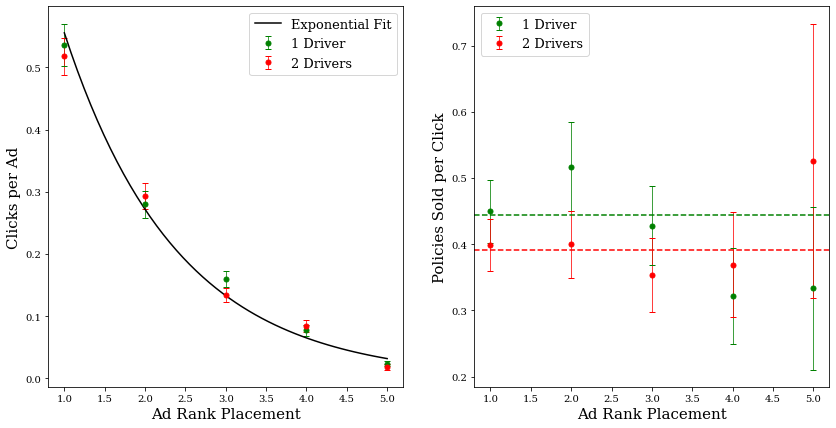

In [16]:
plt.figure(figsize=(14,7))

plt.subplot(1,2,1)

plt.errorbar(x=drivers_df["RankNum"].loc[drivers_df["Drivers"]==1],
             y=drivers_df["Clicks per Ad"].loc[drivers_df["Drivers"]==1],
             yerr=drivers_df["Clicks per Ad Uncertainty"].loc[drivers_df["Drivers"]==1],
             color='g', label='1 Driver',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)
plt.errorbar(x=drivers_df["RankNum"].loc[drivers_df["Drivers"]==2],
             y=drivers_df["Clicks per Ad"].loc[drivers_df["Drivers"]==2],
             yerr=drivers_df["Clicks per Ad Uncertainty"].loc[drivers_df["Drivers"]==2],
             color='r', label='2 Drivers',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)


plt.plot(x, regression_exp, color='k', label='Exponential Fit')

plt.legend(fontsize=13)
plt.xlabel('Ad Rank Placement',fontsize=15)
plt.ylabel('Clicks per Ad',fontsize=15)



plt.subplot(1,2,2)

plt.errorbar(x=drivers_df["RankNum"].loc[drivers_df["Drivers"]==1],
             y=drivers_df["Policies Sold per Click"].loc[drivers_df["Drivers"]==1],
             yerr=drivers_df["Policies Sold per Click Uncertainty"].loc[drivers_df["Drivers"]==1],
             color='g', label='1 Driver',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)
#Include mean for the total set of 1 Driver data
plt.axhline( basic_info("Number of Drivers",1,printout=False)[4],
            color='g', linestyle='--' )

plt.errorbar(x=drivers_df["RankNum"].loc[drivers_df["Drivers"]==2],
             y=drivers_df["Policies Sold per Click"].loc[drivers_df["Drivers"]==2],
             yerr=drivers_df["Policies Sold per Click Uncertainty"].loc[drivers_df["Drivers"]==2],
             color='r', label='2 Drivers',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)
#Include mean for the total set of 2 Driver data
plt.axhline( basic_info("Number of Drivers",2,printout=False)[4],
            color='r', linestyle='--' )

plt.legend(fontsize=13)
plt.xlabel('Ad Rank Placement',fontsize=15)
plt.ylabel('Policies Sold per Click',fontsize=15)

plt.show()

In [17]:
rank_vals = [1,2,3,4,5]
marital_vals = list( set(RootData["Marital Status"]) )

#Define an empty dataframe for us to fill in a second
marital_df = pd.DataFrame({
                        'Status':[],
                        'RankNum':[],
                        'Clicks per Ad':[],
                        'Clicks per Ad Uncertainty':[],
                        'Policies Sold per Click':[],
                        'Policies Sold per Click Uncertainty':[],
                           })

for marital_val in marital_vals:
    cpa_ranks = []
    cpa_err_ranks = []
    pspc_ranks = []
    pspc_err_ranks = []
    for rank_val in rank_vals:
        info_params = basic_info("Marital Status",marital_val,RankNum=rank_val,printout=False)
        #first entry returns clicks per ad
        #second entry returns the uncertainty in clicks per ad
        #fifth entry returns policies sold per click
        #sixth entry returns the uncertainty in policies sold per click
        if not '---' in info_params: #seems an easy way to not deal with empty rank bins
            new_row = {'Status':marital_val, 'RankNum':rank_val, 'Clicks per Ad':info_params[0],
                   'Clicks per Ad Uncertainty':info_params[1], 'Policies Sold per Click':info_params[4],
                    'Policies Sold per Click Uncertainty':info_params[5] }
            marital_df = marital_df.append(new_row, ignore_index=True)

marital_df

,Status,RankNum,Clicks per Ad,Clicks per Ad Uncertainty,Policies Sold per Click,Policies Sold per Click Uncertainty
0,S,1.0,0.564516,0.033102,0.408791,0.040992
1,S,2.0,0.295775,0.022152,0.497835,0.062151
2,S,3.0,0.147527,0.012229,0.395210,0.059814
3,S,4.0,0.094716,0.010167,0.305263,0.066182
4,S,5.0,0.016559,0.003935,0.333333,0.157784
5,M,1.0,0.488199,0.030042,0.437659,0.045573
6,M,2.0,0.279323,0.020787,0.406926,0.053655
7,M,3.0,0.144996,0.011438,0.391304,0.056570
8,M,4.0,0.067219,0.008128,0.397260,0.088851
9,M,5.0,0.025748,0.004684,0.451613,0.146581


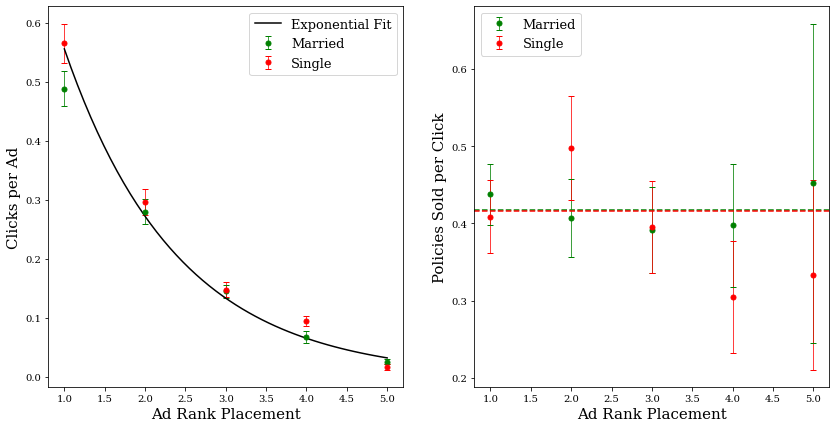

In [18]:
plt.figure(figsize=(14,7))

plt.subplot(1,2,1)

plt.errorbar(x=marital_df["RankNum"].loc[marital_df["Status"]=='M'],
             y=marital_df["Clicks per Ad"].loc[marital_df["Status"]=='M'],
             yerr=drivers_df["Clicks per Ad Uncertainty"].loc[marital_df["Status"]=='M'],
             color='g', label='Married',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)
plt.errorbar(x=marital_df["RankNum"].loc[marital_df["Status"]=='S'],
             y=marital_df["Clicks per Ad"].loc[marital_df["Status"]=='S'],
             yerr=drivers_df["Clicks per Ad Uncertainty"].loc[marital_df["Status"]=='S'],
             color='r', label='Single',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)


plt.plot(x, regression_exp, color='k', label='Exponential Fit')

plt.legend(fontsize=13)
plt.xlabel('Ad Rank Placement',fontsize=15)
plt.ylabel('Clicks per Ad',fontsize=15)



plt.subplot(1,2,2)

plt.errorbar(x=marital_df["RankNum"].loc[marital_df["Status"]=='M'],
             y=marital_df["Policies Sold per Click"].loc[marital_df["Status"]=='M'],
             yerr=drivers_df["Policies Sold per Click Uncertainty"].loc[marital_df["Status"]=='M'],
             color='g', label='Married',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)
#Include mean for the total set of married people
plt.axhline( basic_info("Marital Status",'M',printout=False)[4],
            color='g', linestyle='--' )

plt.errorbar(x=marital_df["RankNum"].loc[marital_df["Status"]=='S'],
             y=marital_df["Policies Sold per Click"].loc[marital_df["Status"]=='S'],
             yerr=drivers_df["Policies Sold per Click Uncertainty"].loc[marital_df["Status"]=='S'],
             color='r', label='Single',
             fmt='o', capsize=3, linewidth=0.75, markersize=5)
#Include mean for the total set of single people
plt.axhline( basic_info("Marital Status",'S',printout=False)[4],
            color='r', linestyle='--' )

plt.legend(fontsize=13)
plt.xlabel('Ad Rank Placement',fontsize=15)
plt.ylabel('Policies Sold per Click',fontsize=15)

plt.show()

So it doesn't look like any of the subsets deviate from what we found for the aggregate rank sample; in all cases clicks per ad as a function of ad rank is well-described by the same exponential decay fit.

### We can also check if rank is correlated with the subsets, to give us an idea on if/how competitors are targeting their bids.

In [19]:
#Printing this out again so I don't have to scroll all the way to the top to see it
RootData

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
0,unknown,2,1,M,10.0,2,False,0
1,Y,3,1,M,10.0,5,False,0
2,Y,3,2,M,10.0,5,False,0
3,N,3,2,S,10.0,4,False,0
4,unknown,2,2,S,10.0,2,False,0
...,...,...,...,...,...,...,...,...
9995,N,1,2,S,10.0,3,True,0
9996,unknown,3,2,M,10.0,3,False,0
9997,Y,3,1,S,10.0,5,False,0
9998,unknown,3,1,M,10.0,3,False,0


In [20]:
def bid_comp(Category=None, Value=None):
    #If we're consistently getting more ranks 1 and 2 than ranks 3 and 4 with our uniform $10 bidding,
    #then we are likely bidding above what competitors are targeting for a given categories
    
    if Category == None:
        ranks = [ len( RootData.loc[RootData["rank"]==i+1] ) for i in range(5) ]
    else:
        ranks = [len( RootData.loc[(RootData["rank"]==i+1) & (RootData[Category]==Value)] ) for i in range(5)]
    
    if ranks[0] + ranks[1] > ranks[3] + ranks[4]:
        print(Category,Value,':',ranks[0],'+',ranks[1],'>',ranks[3],'+',ranks[4])
        print("Competitors are generally bidding LESS than $10")
    elif ranks[0] + ranks[1] < ranks[3] + ranks[4]:
        print(Category,Value,':',ranks[0],'+',ranks[1],'<',ranks[3],'+',ranks[4])
        print("Competitors are generally bidding MORE than $10")

In [21]:
print('Aggregate for all ads:')
bid_comp()
print()
#print('Ads targeting those known to currently have insurance:')
bid_comp("Currently Insured","Y")
#print('Ads targeting those known NOT to currently have insurance:')
bid_comp("Currently Insured","N")
#print('Ads targeting those of unkown insurance status:')
bid_comp("Currently Insured","unknown")
print()
#print('Ads targeting those with 1 vehicle:')
bid_comp("Number of Vehicles",1)
#print('Ads targeting those with 2 vehicles:')
bid_comp("Number of Vehicles",2)
#print('Ads targeting those with 3 vehicles:')
bid_comp("Number of Vehicles",3)
print()
#print('Ads targeting those with 1 driver:')
bid_comp("Number of Drivers",1)
#print('Ads targeting those with 2 drivers:')
bid_comp("Number of Drivers",2)
print()
#print('Ads targeting those who are single:')
bid_comp("Marital Status","S")
#print('Ads targeting those who are married:')
bid_comp("Marital Status","M")
print()

Aggregate for all ads:
None None : 1611 + 1608 < 2089 + 2291
Competitors are generally bidding MORE than $10

Currently Insured Y : 167 + 291 < 961 + 1206
Competitors are generally bidding MORE than $10
Currently Insured N : 122 + 374 < 965 + 1085
Competitors are generally bidding MORE than $10
Currently Insured unknown : 1322 + 943 > 163 + 0
Competitors are generally bidding LESS than $10

Number of Vehicles 1 : 898 + 910 > 531 + 175
Competitors are generally bidding LESS than $10
Number of Vehicles 2 : 561 + 463 < 695 + 1001
Competitors are generally bidding MORE than $10
Number of Vehicles 3 : 152 + 235 < 863 + 1115
Competitors are generally bidding MORE than $10

Number of Drivers 1 : 725 + 740 < 1090 + 1273
Competitors are generally bidding MORE than $10
Number of Drivers 2 : 886 + 868 < 999 + 1018
Competitors are generally bidding MORE than $10

Marital Status S : 806 + 781 < 1003 + 1087
Competitors are generally bidding MORE than $10
Marital Status M : 805 + 827 < 1086 + 1204
Co

This analysis can also be extended to look at all the subcategory permutations. Let's give it a shot.

In [22]:
# I'm curious about looking into this in more detail.
# Let's build a DataFrame!

# The idea I'm aiming to investigate is a model where we pick the N best sets of category combinations
# (based on policies sold per click) and set the bids for all other combinations to a minimum value

insured_vals = list( set(RootData["Currently Insured"]) )
vehicles_vals = list( set(RootData["Number of Vehicles"]) )
drivers_vals = list( set(RootData["Number of Drivers"]) )
marital_vals = list( set(RootData["Marital Status"]) )

categories_df = pd.DataFrame({
                        'Insured':[],
                        'Vehicles':[],
                        'Drivers':[],
                        'Marital Status':[],
                        'Policies Sold per Click':[],
                        'Policies Sold per Click Uncertainty':[],
                        'Total Clicks':[],
                        'Total Click Uncertainty':[],
                        'Total Policies Sold':[],
                        'Total Policies Sold Uncertainty':[],
                        'Expected Policies Sold at Rank 5':[],
                        'Uncertainty in Rank 5 Sales Estimate':[],
                        'Expected Clicks per Ad':[],
                        'AvgRank':[],
                        'Rank1':[],
                        'Rank2':[],
                        'Rank3':[],
                        'Rank4':[],
                        'Rank5':[]
                        })

#Will need the expected clicks per ad for an ad displayed in rank 5 (as well as its uncertainty) in a second
R5ExpClickPA = basic_info("rank",5,printout=False)[0]
R5ErrClickPa = basic_info("rank",5,printout=False)[1]

for insured_val in insured_vals:
    for vehicles_val in vehicles_vals:
        for drivers_val in drivers_vals:
            for marital_val in marital_vals:
                Ranks = [ len(RootData.loc[(RootData["rank"]==i+1) & (RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) & (RootData["Marital Status"]==marital_val)]) for i in range(5) ]
                ad_clicks = len(RootData.loc[(RootData["click"]==True) & (RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) & (RootData["Marital Status"]==marital_val)])
                policies_sold = len(RootData.loc[(RootData["policies_sold"]==1) & (RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) & (RootData["Marital Status"]==marital_val)])
                total_ads = len(RootData.loc[(RootData["Currently Insured"]==insured_val) & (RootData["Number of Vehicles"]==vehicles_val) & (RootData["Number of Drivers"]==drivers_val) & (RootData["Marital Status"]==marital_val)])
                if (Ranks[0]+Ranks[1]+Ranks[2]+Ranks[3]+Ranks[4]) > 0:
                    #probably best to just leave out the empty unknown/3/2/S bin that has no ads
                    #which is what this if statement does
                    
                    clicks_per_ad = ad_clicks/total_ads
                    policies_per_ad = policies_sold/total_ads
                    policies_per_click = policies_per_ad/clicks_per_ad
                    
                    err_clicks_per_ad = clicks_per_ad * np.sqrt((np.sqrt(ad_clicks)/ad_clicks)**2+(np.sqrt(total_ads)/total_ads)**2 )
                    err_policies_per_ad = policies_per_ad * np.sqrt((np.sqrt(policies_sold)/policies_sold)**2+(np.sqrt(total_ads)/total_ads)**2 )
                    err_policies_per_click = policies_per_click * np.sqrt((err_policies_per_ad/policies_per_ad)**2+(err_clicks_per_ad/clicks_per_ad)**2 )
                    
                    ExpClickTot = (fit_exp_betas[0]*np.exp(fit_exp_betas[1]*Ranks[0])) + (fit_exp_betas[0]*np.exp(fit_exp_betas[1]*Ranks[1])) + (fit_exp_betas[0]*np.exp(fit_exp_betas[1]*Ranks[2])) + (fit_exp_betas[0]*np.exp(fit_exp_betas[1]*Ranks[3])) + (fit_exp_betas[0]*np.exp(fit_exp_betas[1]*Ranks[4]))
                    AvgRank = ( 1*Ranks[0]+2*Ranks[1]+3*Ranks[2]+4*Ranks[3]+5*Ranks[4] ) / (Ranks[0]+Ranks[1]+Ranks[2]+Ranks[3]+Ranks[4])
                    ExpClickperAd = (fit_exp_betas[0]*np.exp(fit_exp_betas[1]*AvgRank))
                    
                    #Number of expected clicks if we were to place all ads for customers of these traits in rank 5
                    ExpClickR5 = R5ExpClickPA*(Ranks[0]+Ranks[1]+Ranks[2]+Ranks[3]+Ranks[4])
                    ErrClickR5 = ExpClickR5*np.sqrt(R5ErrClickPa**2)
                    ExpPoliciesR5 = policies_per_click*ExpClickR5
                    ErrPoliciesR5 = ExpPoliciesR5 * np.sqrt( (err_policies_per_click/policies_per_click)**2 + (ErrClickR5/ExpClickR5)**2 )
                    
                    #print(insured_val, vehicles_val, drivers_val, marital_val, AvgRank_Val, policies_per_click)
                    new_row = {'Insured':insured_val, 'Vehicles':vehicles_val, 'Drivers':drivers_val,
                               'Marital Status':marital_val, 'Policies Sold per Click':policies_per_click,
                               'Policies Sold per Click Uncertainty':err_policies_per_click,
                               'Total Clicks':ad_clicks, 'Total Click Uncertainty':np.sqrt(ad_clicks),
                               'Total Policies Sold':policies_sold, 'Total Policies Sold Uncertainty':np.sqrt(policies_sold),
                               'Expected Policies Sold at Rank 5':ExpPoliciesR5,'Uncertainty in Rank 5 Sales Estimate':ErrPoliciesR5,
                               'Expected Clicks per Ad':ExpClickTot, 'AvgRank':AvgRank,
                               'Rank1':Ranks[0],'Rank2':Ranks[1], 'Rank3':Ranks[2],'Rank4':Ranks[3], 'Rank5':Ranks[4]
                               }
                    categories_df = categories_df.append(new_row, ignore_index=True)

categories_df = categories_df.sort_values(by=['Policies Sold per Click'], ascending=False).reset_index(drop=True)
categories_df


,Insured,Vehicles,Drivers,Marital Status,Policies Sold per Click,Policies Sold per Click Uncertainty,Total Clicks,Total Click Uncertainty,Total Policies Sold,Total Policies Sold Uncertainty,Expected Policies Sold at Rank 5,Uncertainty in Rank 5 Sales Estimate,Expected Clicks per Ad,AvgRank,Rank1,Rank2,Rank3,Rank4,Rank5
0,N,3.0,1.0,M,0.600000,0.258296,15.0,3.872983,9.0,3.000000,3.400698,1.464017,2.269116,4.305660,0.0,0.0,51.0,82.0,132.0
1,N,1.0,1.0,S,0.581395,0.154520,43.0,6.557439,25.0,5.000000,3.369860,0.895682,1.134558,3.435424,0.0,59.0,84.0,79.0,49.0
2,N,1.0,1.0,M,0.560000,0.192444,25.0,5.000000,14.0,3.741657,3.593191,1.234849,1.134558,3.573333,0.0,53.0,87.0,95.0,65.0
3,unknown,1.0,1.0,S,0.543307,0.093331,127.0,11.269428,69.0,8.306624,3.253677,0.559019,2.269116,1.621429,148.0,90.0,42.0,0.0,0.0
4,unknown,1.0,2.0,M,0.542857,0.099907,105.0,10.246951,57.0,7.549834,3.413531,0.628312,2.269116,1.659864,155.0,84.0,55.0,0.0,0.0
5,unknown,1.0,1.0,M,0.526786,0.095231,112.0,10.583005,59.0,7.681146,3.312473,0.598907,2.269116,1.690476,150.0,85.0,59.0,0.0,0.0
6,N,3.0,2.0,M,0.523810,0.199229,21.0,4.582576,11.0,3.316625,3.652262,1.389169,2.269116,4.245399,0.0,0.0,71.0,104.0,151.0
7,unknown,2.0,1.0,M,0.488095,0.102101,84.0,9.165151,41.0,6.403124,2.797759,0.585309,2.269116,1.761194,122.0,88.0,58.0,0.0,0.0
8,Y,1.0,1.0,S,0.487179,0.104526,78.0,8.831761,38.0,6.164414,3.021746,0.648391,1.134558,2.548276,60.0,74.0,93.0,63.0,0.0
9,N,2.0,2.0,S,0.468750,0.151346,32.0,5.656854,15.0,3.872983,3.168103,1.022936,1.134558,3.632911,0.0,48.0,94.0,100.0,74.0


In [23]:
# We'll assume for now that the lowest possible bid one can make is $0.01,
# since I doubt the search host would let you bid $0.00
MinBidVal = 0.01

policystats_df = pd.DataFrame({
                        'Set ID':[],
                        'Policies From $10 Bids':[],
                        'Uncertainty in $10 Bid Sales':[],
                        'Policies from Minimum Bids':[],
                        'Uncertainty in Minimum Bid Sales':[],
                        'Total Policies Sold':[],
                        'Uncertainty in Total Sales':[],
                        'Ad Cost Per Policy Sold':[],
                        'Uncertainty in Cost Per Sale':[]
                                })

print(np.arange(25)[0:12+1],np.arange(25)[12+1:-1])

#print('Set ID, Policies From $10 Bids, Policies from Minimum Bids, Total Policies Sold, Ad Cost Per Policy Sold')
for i in range(35):
    TenDollarPolicies = sum(categories_df.iloc[0:i+1]["Total Policies Sold"])
    TenDollarUncertainty = np.sqrt(sum( np.array(categories_df.iloc[0:i+1]["Total Policies Sold Uncertainty"])**2 ))
    MinBidPolicies = sum(categories_df.iloc[i:-1]["Expected Policies Sold at Rank 5"])
    MinBidUncertainty = np.sqrt(sum( np.array(categories_df.iloc[i:-1]["Uncertainty in Rank 5 Sales Estimate"])**2 ))
    TotalPolicies = TenDollarPolicies+MinBidPolicies
    TotalUncertainty = np.sqrt( TenDollarUncertainty**2 + MinBidUncertainty**2 )
    CostPerAd = (10.0*TenDollarPolicies + MinBidVal*MinBidPolicies) / (TenDollarPolicies+MinBidPolicies)
    CostUncertainty = CostPerAd*np.sqrt( ((10.0*TotalUncertainty+MinBidVal*MinBidUncertainty)/(10.0*TenDollarPolicies+MinBidVal*MinBidPolicies))**2 + (TotalUncertainty/TotalPolicies)**2 )
    #print(i,
    #      round(TenDollarPolicies,1), '+/-', round(TenDollarUncertainty,1), ',',
    #      round(MinBidPolicies,1), '+/-', round(MinBidUncertainty,1), ',',
    #      round(TotalPolicies,1), '+/-', round(TotalUncertainty,1), ',',
    #      '$'+str(round(CostPerAd,2)), '+/-', '$'+str(round(CostUncertainty,2))
    #     )
    new_row = {'Set ID':i, 'Policies From $10 Bids':TenDollarPolicies, 'Uncertainty in $10 Bid Sales':TenDollarUncertainty,
               'Policies from Minimum Bids':MinBidPolicies, 'Uncertainty in Minimum Bid Sales':MinBidUncertainty,
               'Total Policies Sold':TotalPolicies, 'Uncertainty in Total Sales':TotalUncertainty,
               'Ad Cost Per Policy Sold':CostPerAd,'Uncertainty in Cost Per Sale':CostUncertainty
                               }
    policystats_df = policystats_df.append(new_row, ignore_index=True)

policystats_df
    

[ 0  1  2  3  4  5  6  7  8  9 10 11 12] [13 14 15 16 17 18 19 20 21 22 23]


,Set ID,Policies From $10 Bids,Uncertainty in $10 Bid Sales,Policies from Minimum Bids,Uncertainty in Minimum Bid Sales,Total Policies Sold,Uncertainty in Total Sales,Ad Cost Per Policy Sold,Uncertainty in Cost Per Sale
0,0.0,9.0,3.000000,82.211919,4.793720,91.211919,5.655064,0.995726,0.623581
1,1.0,34.0,5.830952,78.811220,4.564691,112.811220,7.405161,3.020871,0.686105
2,2.0,48.0,6.928203,75.441360,4.475953,123.441360,8.248282,3.894598,0.717419
3,3.0,117.0,10.816654,71.848170,4.302244,188.848170,11.640846,6.199258,0.725444
4,4.0,174.0,13.190906,68.594493,4.265771,242.594493,13.863506,7.175290,0.703501
5,5.0,233.0,15.264338,65.180962,4.219245,298.180962,15.836730,7.816233,0.674212
6,6.0,244.0,15.620499,61.868489,4.176522,305.868489,16.169210,7.979307,0.676404
7,7.0,285.0,16.881943,58.216227,3.938724,343.216227,17.335327,8.305499,0.656662
8,8.0,323.0,17.972201,55.418467,3.894992,378.418467,18.389425,8.536989,0.639031
9,9.0,338.0,18.384776,52.396721,3.840644,390.396721,18.781655,8.659202,0.636465


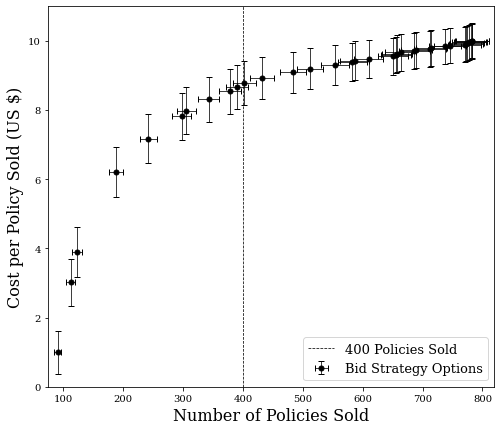

In [24]:
plt.figure(figsize=(8,7))

plt.errorbar(x=policystats_df["Total Policies Sold"], y=policystats_df["Ad Cost Per Policy Sold"],
             xerr=policystats_df["Uncertainty in Total Sales"], yerr=policystats_df["Uncertainty in Cost Per Sale"],
             color='k', fmt='o', capsize=3, linewidth=0.75, markersize=5,label='Bid Strategy Options')

plt.axvline(400,color='k',linestyle='--',linewidth=0.75,label='400 Policies Sold')

plt.legend(fontsize=13,loc='lower right')
plt.xlabel('Number of Policies Sold', fontsize=16)
plt.ylabel('Cost per Policy Sold (US \$)', fontsize=16)

plt.ylim(0,11)
plt.xlim(75,820)

plt.show()

Since the problem specified that they want to ensure that any new bidding strategy is expected to sell more than 400 policies per 10,000 ads shown, we would pick Set ID 10 as our group of customer classification combos to keep at \\\$10 bids, while assigning all other combinations the minimum allowed bid. This will provide the lowest cost per policy sold that yields a total sale count of at least 400.

This would cut the cost per policy sold from \\\$10.00 to \\\$8.78, a savings of more than 12\%.

If management were interested, we could spend less per policy sold if they were willing to accept fewer overall sales. And similarly we could increase sales by spending more per policy sale (while still being more efficient than the flat $10 bid plan) if the goal is to sell between 400 and 783 policies.

Unfortunately this model doesn't allow us to make any quantitative predictions about how to increase sales beyond the 783 policies sold using the current flat $10 bid method.

In [25]:
#List out the category combinations we would be submitting $10 bids for under this strategy
#All others not listed here would get the minimum allowed bid

categories_df[['Insured','Vehicles','Drivers','Marital Status']].iloc[0:10+1]

,Insured,Vehicles,Drivers,Marital Status
0,N,3.0,1.0,M
1,N,1.0,1.0,S
2,N,1.0,1.0,M
3,unknown,1.0,1.0,S
4,unknown,1.0,2.0,M
5,unknown,1.0,1.0,M
6,N,3.0,2.0,M
7,unknown,2.0,1.0,M
8,Y,1.0,1.0,S
9,N,2.0,2.0,S
